In [112]:
# Lead Scoring
#Data Analysis & Data wrangling
import numpy as np
import pandas as pd
from collections import Counter

#Visualization
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
%matplotlib inline

# Plot Style
sns.set_context("paper")
style.use('fivethirtyeight')

# Machine Learning Libraries

#Sci-kit learn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

#statmodel libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [113]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

### Data Loading

In [114]:
df=pd.read_csv('eda.csv')
df.head()

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,What is your current occupation,Lead Quality,Last Notable Activity
0,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,Others,Unemployed,Low in Relevance,Modified
1,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,Others,Unemployed,Not Sure,Email Opened
2,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,Business Administration,Student,Might be,Email Opened
3,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,Media and Advertising,Unemployed,Not Sure,Modified
4,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,Others,Unemployed,Might be,Modified


**Chi square test**

All categorical features against target variable

Ho : All the labels in each categorical variables are having the same effect on target variable


Ha : Atleast one label in each categorical variables are having different effect on target variable
    
- Our goal here is to reject the Ho, which tells that variables are significant
- We keep variables which have p<0.05

In [115]:
from scipy.stats import chi2_contingency
df_obj=df.select_dtypes('object')
for i in df_obj.columns:
    stat, p, dof, expected = chi2_contingency(pd.crosstab(df_obj[i],df['Converted']))
    print('p value of', i, 'is', p)

p value of Lead Origin is 1.93831790477878e-211
p value of Lead Source is 5.807287885111543e-220
p value of Do Not Email is 1.3384599721779416e-38
p value of Do Not Call is 0.2893275634129693
p value of Last Activity is 0.0
p value of Specialization is 2.71408416228191e-46
p value of What is your current occupation is 0.0
p value of Lead Quality is 0.0
p value of Last Notable Activity is 4.239808596196917e-279


- From above chi-square test for the categorical variables we can infer that except 'Do Not Call' all other features are significant.
- We drop 'Do Not Call' and go ahead with the rest for model building

In [116]:
df=df.drop('Do Not Call', axis=1)

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Lead Origin                      9240 non-null   object 
 1   Lead Source                      9240 non-null   object 
 2   Do Not Email                     9240 non-null   object 
 3   Converted                        9240 non-null   int64  
 4   TotalVisits                      9240 non-null   float64
 5   Total Time Spent on Website      9240 non-null   int64  
 6   Page Views Per Visit             9240 non-null   float64
 7   Last Activity                    9240 non-null   object 
 8   Specialization                   9240 non-null   object 
 9   What is your current occupation  9240 non-null   object 
 10  Lead Quality                     9240 non-null   object 
 11  Last Notable Activity            9240 non-null   object 
dtypes: float64(2), int64

#### T-Test for continuous variables

In [118]:
from scipy.stats import ttest_ind
df_numeric = df.select_dtypes(include=np.number)
df_numeric = df_numeric.drop('Converted',1)

In [119]:
df_numeric.columns

Index(['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit'], dtype='object')

In [120]:
for i in df_numeric.columns:
    a = df[df['Converted'] ==0][i]
    b = df[df['Converted'] ==1][i]
    stat,p = ttest_ind(a,b)
    if p < 0.05:
        print('Column',i,'is a significant feature')
        print('Pvalue',p)
        print('\n')
    else:
        print('Column',i,'is NOT significant feature')
        print('Pvalue',p)
        print('\n')

Column TotalVisits is a significant feature
Pvalue 2.5226248223262903e-05


Column Total Time Spent on Website is a significant feature
Pvalue 6.061532215246037e-285


Column Page Views Per Visit is NOT significant feature
Pvalue 0.6491653997727422




- We drop insignificant variables i.e. variables having p-value>0.05
- Here we drop 'Page Views Per Visit' feature

In [121]:
df=df.drop('Page Views Per Visit', axis=1)

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Lead Origin                      9240 non-null   object 
 1   Lead Source                      9240 non-null   object 
 2   Do Not Email                     9240 non-null   object 
 3   Converted                        9240 non-null   int64  
 4   TotalVisits                      9240 non-null   float64
 5   Total Time Spent on Website      9240 non-null   int64  
 6   Last Activity                    9240 non-null   object 
 7   Specialization                   9240 non-null   object 
 8   What is your current occupation  9240 non-null   object 
 9   Lead Quality                     9240 non-null   object 
 10  Last Notable Activity            9240 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 794.2+ KB


**Data Preparation**

In [123]:
df.head()

,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Last Activity,Specialization,What is your current occupation,Lead Quality,Last Notable Activity
0,API,Olark Chat,No,0,0.0,0,Page Visited on Website,Others,Unemployed,Low in Relevance,Modified
1,API,Organic Search,No,0,5.0,674,Email Opened,Others,Unemployed,Not Sure,Email Opened
2,Landing Page Submission,Direct Traffic,No,1,2.0,1532,Email Opened,Business Administration,Student,Might be,Email Opened
3,Landing Page Submission,Direct Traffic,No,0,1.0,305,Unreachable,Media and Advertising,Unemployed,Not Sure,Modified
4,Landing Page Submission,Google,No,1,2.0,1428,Converted to Lead,Others,Unemployed,Might be,Modified


Converting binary variables(yes/no) to 1/0

In [124]:
df['Do Not Email']=df['Do Not Email'].replace({'Yes': 1, "No": 0})

**Dummy Variables for categorical columns**

In [125]:
df.columns

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Converted',
       'TotalVisits', 'Total Time Spent on Website', 'Last Activity',
       'Specialization', 'What is your current occupation', 'Lead Quality',
       'Last Notable Activity'],
      dtype='object')

In [126]:
dummy=pd.get_dummies(df[['Lead Origin', 'Lead Source', 'Last Activity', 'Specialization',
       'What is your current occupation', 'Lead Quality',
       'Last Notable Activity']],drop_first=True)

In [127]:
df=pd.concat([df,dummy],axis=1)

In [128]:
df=df.drop(['Lead Origin', 'Lead Source', 'Last Activity', 'Specialization',
       'What is your current occupation', 'Lead Quality',
       'Last Notable Activity'], axis=1)

In [129]:
df.head()

,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Facebook,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Others,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Olark Chat Conversation,Last Activity_Other_Activity,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Lead Quality_Low in Relevance,Lead Quality_Might be,Lead Quality_Not Sure,Lead Quality_Worst,Last Notable Activity_Email Bounced,Last Notable Activity_Email Link Clicked,Last Notable Activity_Email Marked Spam,Last Notable Activity_Email Opened,Last Notable Activity_Email Received,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
0,0,0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,5.0,674,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,1,2.0,1532,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1.0,305,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,1,2.0,1428,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 68 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Do Not Email                                          9240 non-null   int64  
 1   Converted                                             9240 non-null   int64  
 2   TotalVisits                                           9240 non-null   float64
 3   Total Time Spent on Website                           9240 non-null   int64  
 4   Lead Origin_Landing Page Submission                   9240 non-null   uint8  
 5   Lead Origin_Lead Add Form                             9240 non-null   uint8  
 6   Lead Origin_Lead Import                               9240 non-null   uint8  
 7   Lead Origin_Quick Add Form                            9240 non-null   uint8  
 8   Lead Source_Facebook                                  9240

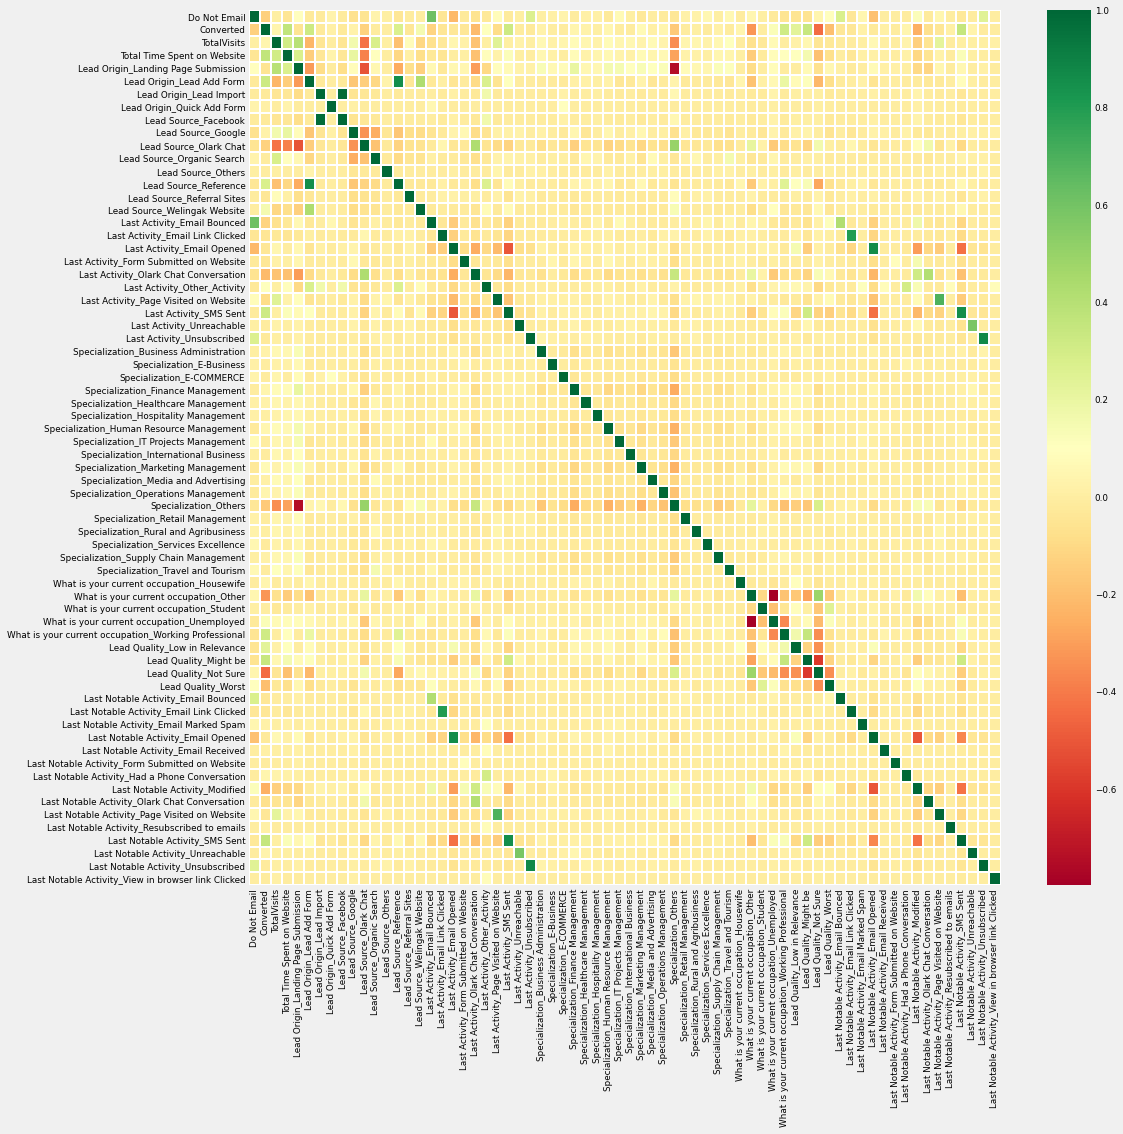

In [131]:
plt.figure(figsize=[15,15])
sns.heatmap(df.corr(), cmap="RdYlGn",linewidth =1)
plt.show()

In [132]:
df.corr()

,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Facebook,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Others,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Olark Chat Conversation,Last Activity_Other_Activity,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Lead Quality_Low in Relevance,Lead Quality_Might be,Lead Quality_Not Sure,Lead Quality_Worst,Last Notable Activity_Email Bounced,Last Notable Activity_Email Link Clicked,Last Notable Activity_Email Marked Spam,Last Notable Activity_Email Opened,Last Notable Activity_Email Received,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
Do Not Email,1.000000,-0.135580,0.007098,-0.046374,0.095304,-0.020983,-0.017529,0.035416,-0.017529,-0.062113,-0.051436,0.034295,0.009421,-0.038451,-0.010149,-0.000911,0.618470,-0.043505,-0.218621,-0.018744,-0.055143,-0.028865,0.082217,-0.017564,0.006465,0.262686,0.003893,0.012636,0.033293,-0.004597,0.013447,0.010674,-0.019910,0.069613,0.005416,-0.027271,-0.000343,-0.014036,-0.037805,0.023426,0.028032,0.053781,0.002680,0.059722,-0.009669,0.049287,0.006225,-0.019533,-0.049841,-0.049895,-0.054403,0.044515,0.096170,0.275213,-0.037624,0.050089,-0.188089,-0.003056,-0.003056,-0.011443,0.117259,-0.013032,0.049921,-0.003056,-0.025990,-0.010505,0.243408,-0.003056
Converted,-0.135580,1.000000,0.043811,0.362483,-0.051236,0.321702,-0.023695,0.013138,-0.023695,0.026286,-0.129459,-0.005879,0.000607,0.270830,-0.033058,0.154153,-0.120095,-0.039690,-0.032934,-0.033364,-0.210809,0.101876,-0.083771,0.325600,-0.010785,-0.020618,0.025791,-0.002747,-0.006429,0.043308,0.030306,0.008190,0.047130,-0.001200,-0.007441,0.065853,0.010264,0.043272,-0.154025,-0.009755,0.007200,-0.014956,0.019245,-0.009457,0.041567,-0.323908,-0.004375,0.128710,0.313837,0.230770,0.342988,-0.446879,-0.198039,-0.039101,-0.035555,0.018581,-0.021955,0.013138,-0.008238,0.043476,-0.244294,-0.072660,-0.036051,0.013138,0.351845,0.036594,-0.012858,-0.008238
TotalVisits,0.007098,0.043811,1.000000,0.310555,0.390116,-0.226458,-0.043452,-0.001179,-0.041820,0.159154,-0.425907,0.282534,0.005676,-0.190680,0.085894,-0.104736,-0.062503,-0.025920,0.047132,0.020202,-0.186432,0.006329,0.244246,0.003932,0.026933,0.007426,0.060472,0.023539,0.038213,0.074092,0.050408,0.024011,0.079316,0.045052,0.052847,0.036669,0.066090,0.036718,-0.348027,0.043354,0.046608,0.025991,0.058381,0.101205,-0.008503,-0.064727,-0.030130,0.069919,-0.001879

In [133]:
df.shape

(9240, 68)

There are total 68 columns after one hot encoding. This will applied further in model building

**Handling Multicollinearity**

In [134]:

#function to calculate VIF
def calculate_VIF(df):  # Calculate VIF for features
    vif = pd.DataFrame()
    vif['Features'] = df.columns # Read the feature names
    vif['VIF'] = [variance_inflation_factor(df.values,i) for i in range(df.shape[1])] # calculate VIF
    vif['VIF'] = round(vif['VIF'],2)
    vif.sort_values(by='VIF', ascending = False, inplace=True)  
    return(vif) # returns the calculated VIFs for all the features

In [135]:
calculate_VIF(df)

,Features,VIF
47,What is your current occupation_Unemployed,630.82
60,Last Notable Activity_Modified,405.72
56,Last Notable Activity_Email Opened,342.95
45,What is your current occupation_Other,306.06
64,Last Notable Activity_SMS Sent,264.14
48,What is your current occupation_Working Profes...,80.62
62,Last Notable Activity_Page Visited on Website,39.69
6,Lead Origin_Lead Import,27.93
8,Lead Source_Facebook,27.90
46,What is your current occupation_Student,24.74


In [ ]:
df=df.drop('What is your current occupation_Unemployed', axis=1)

In [138]:
calculate_VIF(df)

,Features,VIF
55,Last Notable Activity_Email Opened,31.90
59,Last Notable Activity_Modified,31.24
6,Lead Origin_Lead Import,27.93
8,Lead Source_Facebook,27.90
63,Last Notable Activity_SMS Sent,25.17
5,Lead Origin_Lead Add Form,18.70
13,Lead Source_Reference,15.03
50,Lead Quality_Not Sure,14.61
38,Specialization_Others,14.56
18,Last Activity_Email Opened,14.29


In [139]:
df=df.drop('Last Notable Activity_Email Opened', axis=1)

In [140]:
calculate_VIF(df)

,Features,VIF
6,Lead Origin_Lead Import,27.92
8,Lead Source_Facebook,27.90
5,Lead Origin_Lead Add Form,18.67
13,Lead Source_Reference,14.92
50,Lead Quality_Not Sure,12.15
23,Last Activity_SMS Sent,10.73
38,Specialization_Others,10.43
18,Last Activity_Email Opened,9.47
62,Last Notable Activity_SMS Sent,8.60
4,Lead Origin_Landing Page Submission,7.30


In [141]:
df=df.drop('Lead Origin_Lead Import', axis=1)

In [142]:
calculate_VIF(df)

,Features,VIF
5,Lead Origin_Lead Add Form,18.67
12,Lead Source_Reference,14.92
49,Lead Quality_Not Sure,12.14
22,Last Activity_SMS Sent,10.73
37,Specialization_Others,10.43
17,Last Activity_Email Opened,9.46
61,Last Notable Activity_SMS Sent,8.60
4,Lead Origin_Landing Page Submission,7.29
57,Last Notable Activity_Modified,5.56
14,Lead Source_Welingak Website,4.69


In [143]:
df=df.drop('Lead Origin_Lead Add Form', axis=1)

In [144]:
calculate_VIF(df)

,Features,VIF
48,Lead Quality_Not Sure,12.14
21,Last Activity_SMS Sent,10.72
36,Specialization_Others,10.42
16,Last Activity_Email Opened,9.44
60,Last Notable Activity_SMS Sent,8.59
4,Lead Origin_Landing Page Submission,7.25
56,Last Notable Activity_Modified,5.56
23,Last Activity_Unsubscribed,4.60
62,Last Notable Activity_Unsubscribed,4.46
8,Lead Source_Olark Chat,3.66


In [145]:
df=df.drop('Lead Quality_Not Sure', axis=1)
calculate_VIF(df)

,Features,VIF
21,Last Activity_SMS Sent,10.47
16,Last Activity_Email Opened,8.71
36,Specialization_Others,8.59
59,Last Notable Activity_SMS Sent,8.42
4,Lead Origin_Landing Page Submission,6.81
55,Last Notable Activity_Modified,5.38
23,Last Activity_Unsubscribed,4.60
61,Last Notable Activity_Unsubscribed,4.46
8,Lead Source_Olark Chat,3.63
18,Last Activity_Olark Chat Conversation,3.51


In [146]:
df=df.drop('Last Activity_SMS Sent', axis=1)
calculate_VIF(df)

,Features,VIF
35,Specialization_Others,7.89
4,Lead Origin_Landing Page Submission,6.56
16,Last Activity_Email Opened,6.44
58,Last Notable Activity_SMS Sent,5.60
54,Last Notable Activity_Modified,5.17
22,Last Activity_Unsubscribed,4.52
60,Last Notable Activity_Unsubscribed,4.45
8,Lead Source_Olark Chat,3.48
2,TotalVisits,3.23
1,Converted,3.14


In [147]:
df=df.drop('Specialization_Others', axis=1)
calculate_VIF(df)

,Features,VIF
4,Lead Origin_Landing Page Submission,6.47
22,Last Activity_Unsubscribed,4.51
59,Last Notable Activity_Unsubscribed,4.44
16,Last Activity_Email Opened,4.05
53,Last Notable Activity_Modified,3.73
57,Last Notable Activity_SMS Sent,3.65
2,TotalVisits,3.23
8,Lead Source_Olark Chat,3.22
1,Converted,3.14
15,Last Activity_Email Link Clicked,3.08


In [148]:
df=df.drop('Lead Origin_Landing Page Submission', axis=1)
calculate_VIF(df)

,Features,VIF
21,Last Activity_Unsubscribed,4.51
58,Last Notable Activity_Unsubscribed,4.44
15,Last Activity_Email Opened,3.63
52,Last Notable Activity_Modified,3.49
56,Last Notable Activity_SMS Sent,3.27
2,TotalVisits,3.19
1,Converted,3.13
14,Last Activity_Email Link Clicked,3.08
47,Last Notable Activity_Email Link Clicked,3.03
7,Lead Source_Olark Chat,2.79


In [149]:
df.shape

(9240, 60)

**Train Test Split**

In [150]:
X=df.drop(['Converted'], axis=1)
y=df['Converted']

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=7)

**Feature Scaling**

In [152]:
scaler = StandardScaler()

X_train[['TotalVisits','Total Time Spent on Website']] = scaler.fit_transform(X_train[['TotalVisits','Total Time Spent on Website']])

X_train.head()

,Do Not Email,TotalVisits,Total Time Spent on Website,Lead Origin_Quick Add Form,Lead Source_Facebook,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Others,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Olark Chat Conversation,Last Activity_Other_Activity,Last Activity_Page Visited on Website,Last Activity_Unreachable,Last Activity_Unsubscribed,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Working Professional,Lead Quality_Low in Relevance,Lead Quality_Might be,Lead Quality_Worst,Last Notable Activity_Email Bounced,Last Notable Activity_Email Link Clicked,Last Notable Activity_Email Marked Spam,Last Notable Activity_Email Received,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
8601,0,0.473917,2.185342,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
463,0,-0.402967,-0.695063,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2311,0,0.181622,0.743303,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4409,0,-0.987556,-0.882436,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
452,0,0.181622,1.610363,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [153]:
X_test[['TotalVisits','Total Time Spent on Website']] = scaler.transform(X_test[['TotalVisits','Total Time Spent on Website']])

X_test.head()

,Do Not Email,TotalVisits,Total Time Spent on Website,Lead Origin_Quick Add Form,Lead Source_Facebook,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Others,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Olark Chat Conversation,Last Activity_Other_Activity,Last Activity_Page Visited on Website,Last Activity_Unreachable,Last Activity_Unsubscribed,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Working Professional,Lead Quality_Low in Relevance,Lead Quality_Might be,Lead Quality_Worst,Last Notable Activity_Email Bounced,Last Notable Activity_Email Link Clicked,Last Notable Activity_Email Marked Spam,Last Notable Activity_Email Received,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
2567,0,-0.695261,1.017015,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
8449,0,0.473917,1.046406,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
194,0,0.473917,-0.314805,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4251,0,-0.402967,-0.246836,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6230,0,1.643095,0.019528,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


**Importing Modules**

In [154]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, plot_confusion_matrix, roc_curve, recall_score

### User-Defined Functions

In [155]:
def plot_cm(y_test,y_pred):
    cm = confusion_matrix(y_test,y_pred)
    conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:No','Predicted:Yes'], 
                           index = ['Actual:No','Actual:Yes'])
    sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})
    

In [156]:
def plot_roc(y_test,y_pred):
    fpr, tpr, thresholds = roc_curve(y_test,y_pred)
    plt.plot(fpr, tpr)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
    plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
    plt.title('ROC curve', fontsize = 15)
    plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
    plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
    plt.text(x = 0.02, y = 0.9, s = ('AUC Score for full model:',round(roc_auc_score(y_test, y_pred),4)))


In [157]:
def print_cr(y_test,y_pred):
    print(classification_report(y_test,y_pred))
    print(recall_score(y_test,y_pred))

# **Model Building**

**Logistic Regression**

In [158]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
lr_model=logreg.fit(X_train,y_train)

**Test Results**

In [159]:
y_pred_lr=lr_model.predict(X_test)

In [160]:
from sklearn.metrics import accuracy_score
print('Test Accuracy')
accuracy_score(y_test,y_pred_lr)

Test Accuracy


0.8427128427128427

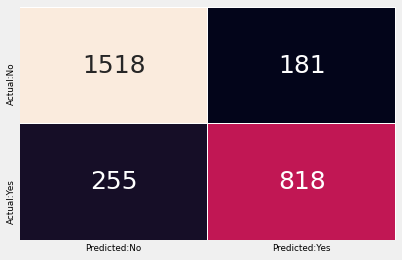

In [161]:
plot_cm(y_test,y_pred_lr)

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1699
           1       0.82      0.76      0.79      1073

    accuracy                           0.84      2772
   macro avg       0.84      0.83      0.83      2772
weighted avg       0.84      0.84      0.84      2772

0.7623485554520038


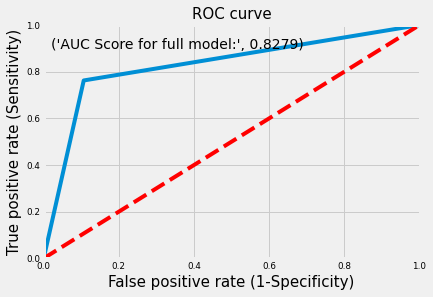

In [162]:
plot_roc(y_test,y_pred_lr)
print_cr(y_test,y_pred_lr)

**Train Results**

In [163]:
y_pred_lr_train=lr_model.predict(X_train)

In [164]:
from sklearn.metrics import accuracy_score
print('Train Accuracy')
accuracy_score(y_train,y_pred_lr_train)

Train Accuracy


0.8302411873840445

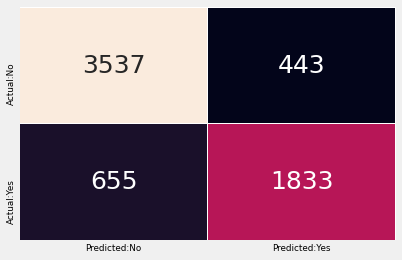

In [165]:
plot_cm(y_train,y_pred_lr_train)

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      3980
           1       0.81      0.74      0.77      2488

    accuracy                           0.83      6468
   macro avg       0.82      0.81      0.82      6468
weighted avg       0.83      0.83      0.83      6468

0.7367363344051447


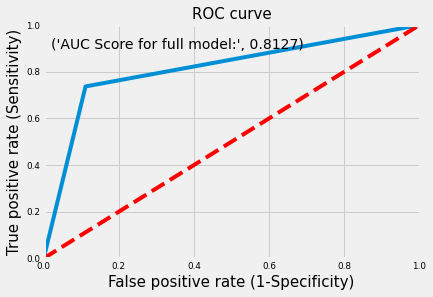

In [166]:
plot_roc(y_train,y_pred_lr_train)
print_cr(y_train,y_pred_lr_train)

#### Build a full logistic model on a training dataset (logit)

In [167]:
# build the model on train data (X_train and y_train)
# use fit() to fit the logistic regression model
import statsmodels.api as sm
xlog = sm.add_constant(X_train)
logreg = sm.Logit(y_train, xlog).fit()

# print the summary of the model
print(logreg.summary())

         Current function value: 0.372296
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:              Converted   No. Observations:                 6468
Model:                          Logit   Df Residuals:                     6408
Method:                           MLE   Df Model:                           59
Date:                Sat, 15 May 2021   Pseudo R-squ.:                  0.4412
Time:                        13:34:17   Log-Likelihood:                -2408.0
converged:                      False   LL-Null:                       -4309.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -1.5

In [111]:
xt = sm.add_constant(X_test)
y_pred_prob = logreg.predict(xt)
y_pred_prob.head()

2567    0.179082
8449    0.473406
194     0.021644
4251    0.091150
6230    0.956383
dtype: float64

#### Train test split for unscaled, sampled data

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=7)

**Decision Tree**

In [169]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train)

y_pred_dt= dt.predict(X_test)

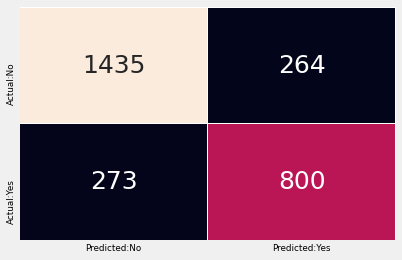

In [170]:
plot_cm(y_test,y_pred_dt)

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1699
           1       0.75      0.75      0.75      1073

    accuracy                           0.81      2772
   macro avg       0.80      0.80      0.80      2772
weighted avg       0.81      0.81      0.81      2772

0.7455731593662628


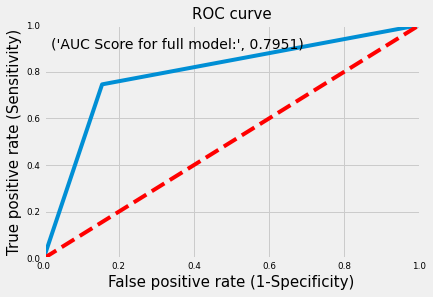

In [171]:
plot_roc(y_test,y_pred_dt)
print_cr(y_test,y_pred_dt)

In [172]:
## Train part
y_pred_dt_train = dt.predict(X_train)
print_cr(y_train,y_pred_dt_train)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3980
           1       0.98      0.96      0.97      2488

    accuracy                           0.98      6468
   macro avg       0.98      0.97      0.97      6468
weighted avg       0.98      0.98      0.98      6468

0.9590032154340836


**Random Forest**

In [173]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train)

y_pred_rf= rf.predict(X_test)

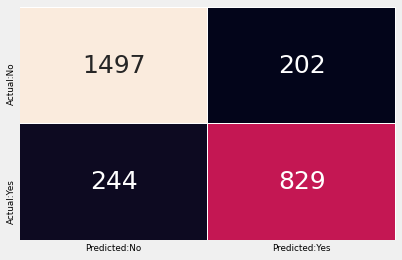

In [174]:
plot_cm(y_test,y_pred_rf)

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1699
           1       0.80      0.77      0.79      1073

    accuracy                           0.84      2772
   macro avg       0.83      0.83      0.83      2772
weighted avg       0.84      0.84      0.84      2772

0.7726001863932899


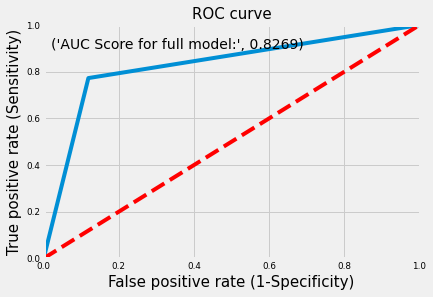

In [175]:
plot_roc(y_test,y_pred_rf)
print_cr(y_test,y_pred_rf)

In [176]:
## Train part
y_pred_rf_train = rf.predict(X_train)
print_cr(y_train,y_pred_rf_train)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3980
           1       0.97      0.96      0.97      2488

    accuracy                           0.98      6468
   macro avg       0.98      0.97      0.97      6468
weighted avg       0.98      0.98      0.98      6468

0.9606109324758842


## AdaBoost


In [177]:
abc = AdaBoostClassifier(random_state = 0)
abc.fit(X_train,y_train)

y_pred_abc= abc.predict(X_test)

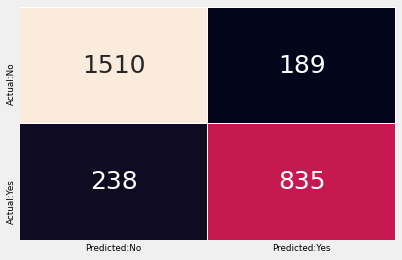

In [178]:
plot_cm(y_test,y_pred_abc)

              precision    recall  f1-score   support

           0       0.86      0.89      0.88      1699
           1       0.82      0.78      0.80      1073

    accuracy                           0.85      2772
   macro avg       0.84      0.83      0.84      2772
weighted avg       0.85      0.85      0.85      2772

0.7781919850885368


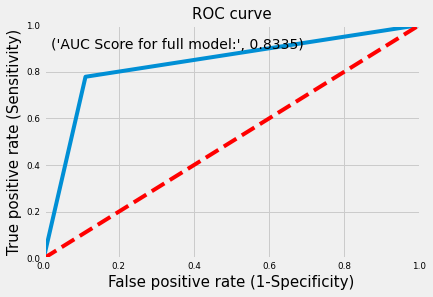

In [179]:
plot_roc(y_test,y_pred_abc)
print_cr(y_test,y_pred_abc)

In [180]:
## Train part
y_pred_abc_train = abc.predict(X_train)
print_cr(y_train,y_pred_abc_train)

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      3980
           1       0.81      0.76      0.78      2488

    accuracy                           0.84      6468
   macro avg       0.83      0.82      0.83      6468
weighted avg       0.84      0.84      0.84      6468

0.7612540192926045


## Gradient Boosting

In [181]:
gbc = GradientBoostingClassifier(random_state = 0)
gbc.fit(X_train,y_train)

y_pred_gbc= gbc.predict(X_test)

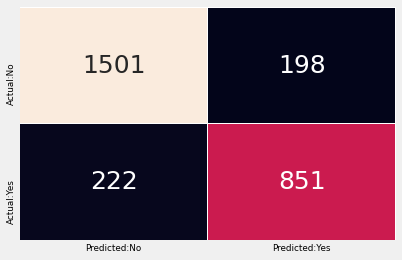

In [182]:
plot_cm(y_test,y_pred_gbc)

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1699
           1       0.81      0.79      0.80      1073

    accuracy                           0.85      2772
   macro avg       0.84      0.84      0.84      2772
weighted avg       0.85      0.85      0.85      2772

0.7931034482758621


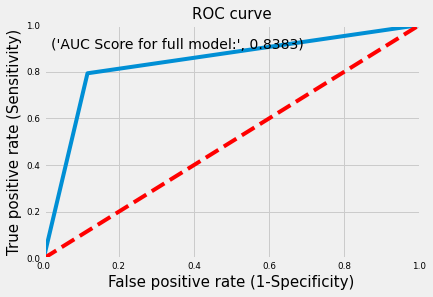

In [183]:
plot_roc(y_test,y_pred_gbc)
print_cr(y_test,y_pred_gbc)

In [184]:
## Train part
y_pred_gbc_train = gbc.predict(X_train)
print_cr(y_train,y_pred_gbc_train)

              precision    recall  f1-score   support

           0       0.87      0.90      0.88      3980
           1       0.83      0.79      0.81      2488

    accuracy                           0.86      6468
   macro avg       0.85      0.84      0.85      6468
weighted avg       0.85      0.86      0.85      6468

0.7897909967845659


## XG BOOST

In [185]:
xgb = XGBClassifier(random_state = 0)
xgb.fit(X_train,y_train)

y_pred_xgb= xgb.predict(X_test)

[13:40:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


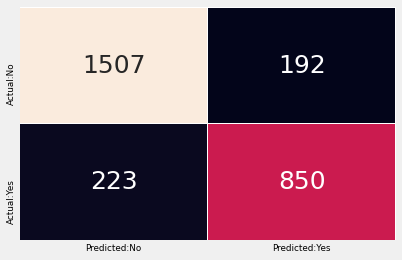

In [186]:
plot_cm(y_test,y_pred_xgb)

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1699
           1       0.82      0.79      0.80      1073

    accuracy                           0.85      2772
   macro avg       0.84      0.84      0.84      2772
weighted avg       0.85      0.85      0.85      2772

0.7921714818266542


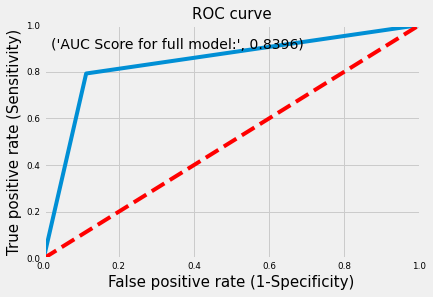

In [187]:
plot_roc(y_test,y_pred_xgb)
print_cr(y_test,y_pred_xgb)

In [188]:
## Train part
y_pred_xgb_train = xgb.predict(X_train)
print_cr(y_train,y_pred_xgb_train)

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      3980
           1       0.90      0.86      0.88      2488

    accuracy                           0.91      6468
   macro avg       0.91      0.90      0.90      6468
weighted avg       0.91      0.91      0.91      6468

0.8605305466237942


## Naive Bayes

In [189]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)

y_pred_gnb= gnb.predict(X_test)

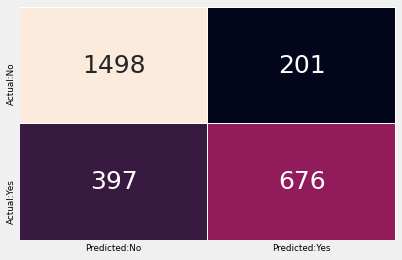

In [190]:
plot_cm(y_test,y_pred_gnb)

              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1699
           1       0.77      0.63      0.69      1073

    accuracy                           0.78      2772
   macro avg       0.78      0.76      0.76      2772
weighted avg       0.78      0.78      0.78      2772

0.630009319664492


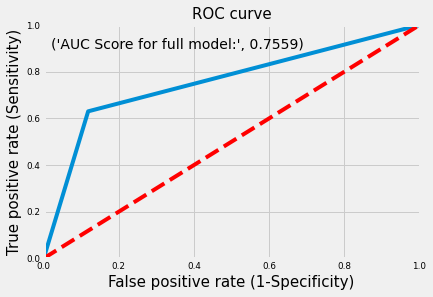

In [191]:
plot_roc(y_test,y_pred_gnb)
print_cr(y_test,y_pred_gnb)

In [192]:
#Train part
y_pred_gnb_train = gnb.predict(X_train)
print_cr(y_train,y_pred_gnb_train)

              precision    recall  f1-score   support

           0       0.79      0.88      0.83      3980
           1       0.77      0.62      0.69      2488

    accuracy                           0.78      6468
   macro avg       0.78      0.75      0.76      6468
weighted avg       0.78      0.78      0.78      6468

0.6197749196141479


In [193]:
df=pd.DataFrame({'Model':['Logistic_Regression','Decision Tree','Random Forest','AdaBoost','Gradient Boosting','XG BOOST',
                          'Naive Bayes'],
                'Test Accuracy':[accuracy_score(y_test,y_pred_lr),accuracy_score(y_test,y_pred_dt),
                            accuracy_score(y_test,y_pred_rf),accuracy_score(y_test,y_pred_abc),
                                 accuracy_score(y_test,y_pred_gbc),accuracy_score(y_test,y_pred_xgb),
                                accuracy_score(y_test,y_pred_gnb)],
                 'Train Accuracy':[accuracy_score(y_train,y_pred_lr_train),accuracy_score(y_train,y_pred_dt_train),
                            accuracy_score(y_train,y_pred_rf_train),accuracy_score(y_train,y_pred_abc_train),
                                  accuracy_score(y_train,y_pred_gbc_train),accuracy_score(y_train,y_pred_xgb_train),
                                  accuracy_score(y_test,y_pred_gnb)],
                'Test Recall':[recall_score(y_test,y_pred_lr),recall_score(y_test,y_pred_dt),
                          recall_score(y_test,y_pred_rf),recall_score(y_test,y_pred_abc),recall_score(y_test,y_pred_gbc),
                              recall_score(y_test,y_pred_xgb),accuracy_score(y_test,y_pred_gnb)]})
df

,Model,Test Accuracy,Train Accuracy,Test Recall
0,Logistic_Regression,0.842713,0.830241,0.762349
1,Decision Tree,0.806277,0.975263,0.745573
2,Random Forest,0.839105,0.975263,0.772600
3,AdaBoost,0.845960,0.837817,0.778192
4,Gradient Boosting,0.848485,0.855597,0.793103
5,XG BOOST,0.850289,0.909400,0.792171
6,Naive Bayes,0.784271,0.784271,0.784271


### Final Model

We consider Logistic Regression as the final model based on above scores of different models

- We will try to improve the model using
    - RFE
    - Hyper Parameter Tuning

### RFE

In [194]:
logreg_final = LogisticRegression()
rfe = RFE(logreg_final, 20)           
rfe = rfe.fit(X_train, y_train)

In [196]:
#checking which columns remained after RFE
rfe_col = X_train.columns[rfe.support_]
rfe_col

Index(['Do Not Email', 'Lead Origin_Quick Add Form', 'Lead Source_Reference',
       'Lead Source_Welingak Website', 'Last Activity_Email Bounced',
       'Last Activity_Olark Chat Conversation',
       'What is your current occupation_Housewife',
       'What is your current occupation_Other',
       'What is your current occupation_Working Professional',
       'Lead Quality_Low in Relevance', 'Lead Quality_Might be',
       'Lead Quality_Worst', 'Last Notable Activity_Email Bounced',
       'Last Notable Activity_Email Marked Spam',
       'Last Notable Activity_Had a Phone Conversation',
       'Last Notable Activity_Olark Chat Conversation',
       'Last Notable Activity_Resubscribed to emails',
       'Last Notable Activity_SMS Sent', 'Last Notable Activity_Unreachable',
       'Last Notable Activity_Unsubscribed'],
      dtype='object')

In [197]:
features = list(rfe_col) #  Use RFE selected variables

In [198]:
X_train_rfe = X_train[features]

In [199]:
X_test_rfe = X_test[features]

In [200]:
logreg_fm=LogisticRegression()
lr_model_fm=logreg_fm.fit(X_train_rfe,y_train)

**Test Results**

In [201]:
y_pred_lr_fm=lr_model_fm.predict(X_test_rfe)

In [202]:
from sklearn.metrics import accuracy_score
print('Test Accuracy')
accuracy_score(y_test,y_pred_lr_fm)

Test Accuracy


0.8026695526695526

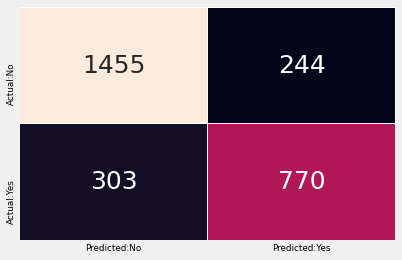

In [203]:
plot_cm(y_test,y_pred_lr_fm)

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      1699
           1       0.76      0.72      0.74      1073

    accuracy                           0.80      2772
   macro avg       0.79      0.79      0.79      2772
weighted avg       0.80      0.80      0.80      2772

0.7176141658900279


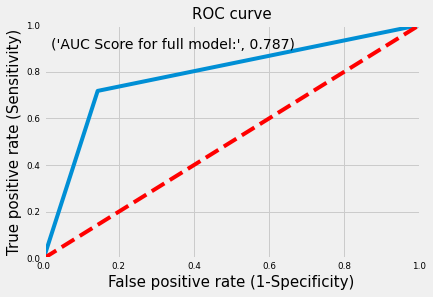

In [204]:
plot_roc(y_test,y_pred_lr_fm)
print_cr(y_test,y_pred_lr_fm)

**Train Results**

In [206]:
y_pred_lr_train_fm=lr_model_fm.predict(X_train_rfe)

In [207]:
from sklearn.metrics import accuracy_score
print('Train Accuracy')
accuracy_score(y_train,y_pred_lr_train_fm)

Train Accuracy


0.7884972170686456

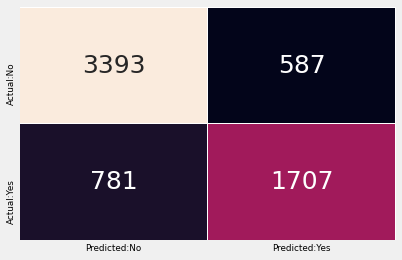

In [208]:
plot_cm(y_train,y_pred_lr_train_fm)

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      3980
           1       0.74      0.69      0.71      2488

    accuracy                           0.79      6468
   macro avg       0.78      0.77      0.77      6468
weighted avg       0.79      0.79      0.79      6468

0.6860932475884244


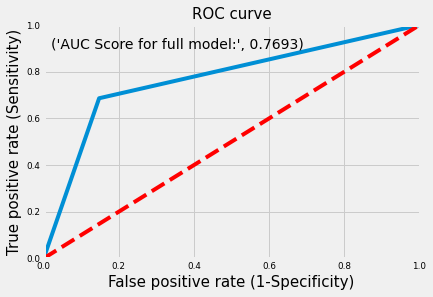

In [209]:
plot_roc(y_train,y_pred_lr_train_fm)
print_cr(y_train,y_pred_lr_train_fm)

### Hyper Parameter Tuning

In [236]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
logreg=LogisticRegression()
param_grid=[{'penalty' : ['l1', 'l2', 'elasticnet'],
             'solver':[ 'liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
    'l1_ratio' : np.arange(0, 1, 0.1)}]
lr=GridSearchCV(logreg,param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
lr.fit(X_train,y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 582 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  1.8min finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                          'penalty': ['l1', 'l2', 'elasticnet'],
                          'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag',
                                     'saga']}],
             verbose=True)

In [237]:
lr.best_params_

{'l1_ratio': 0.0, 'penalty': 'l2', 'solver': 'newton-cg'}

### Test Results

In [238]:
lr_final=LogisticRegression(l1_ratio=0.0, penalty='l2',solver='newton-cg')
lr_final_model=lr_final.fit(X_train,y_train)
y_pred_lr=lr_final_model.predict(X_test)

In [239]:
from sklearn.metrics import accuracy_score
print('Test Accuracy')
accuracy_score(y_test,y_pred_lr)

Test Accuracy


0.8423520923520924

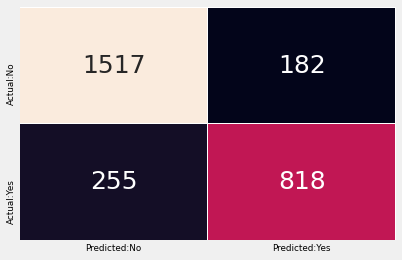

In [240]:
plot_cm(y_test,y_pred_lr)

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1699
           1       0.82      0.76      0.79      1073

    accuracy                           0.84      2772
   macro avg       0.84      0.83      0.83      2772
weighted avg       0.84      0.84      0.84      2772

0.7623485554520038


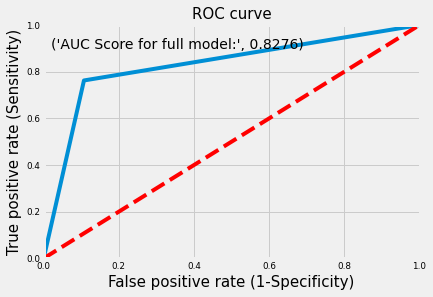

In [241]:
plot_roc(y_test,y_pred_lr)
print_cr(y_test,y_pred_lr)

### Train Results

In [246]:
y_pred_lr_train=lr_final_model.predict(X_train)

In [247]:
from sklearn.metrics import accuracy_score
print('Train Accuracy')
accuracy_score(y_train,y_pred_lr_train)

Train Accuracy


0.8303957946815089

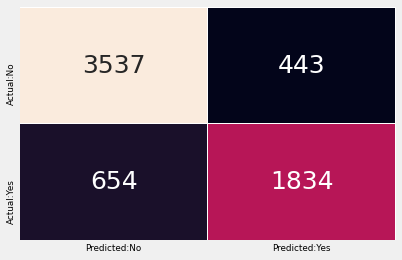

In [248]:
plot_cm(y_train,y_pred_lr_train)

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      3980
           1       0.81      0.74      0.77      2488

    accuracy                           0.83      6468
   macro avg       0.82      0.81      0.82      6468
weighted avg       0.83      0.83      0.83      6468

0.7371382636655949


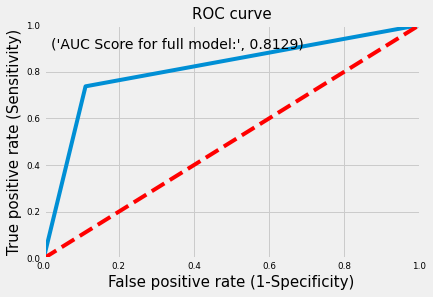

In [249]:
plot_roc(y_train,y_pred_lr_train)
print_cr(y_train,y_pred_lr_train)

### Conclusion

- We perform EDA, univariate and bivariate analysis to get inferences on the attributes
- Feature selection is done using statistical analysis
- Various models are build and compared. We get the best result in Logistic Regression
- After RFE and implementing HyperParameter Tuning, there is no improvement in the evaluation metrics
- We therefore consider Logistic Regression with its base parameters as the final model
- Metrics score to be considered is Accuracy and Recall
- We need a better recall score and reduce False negatives as predicting a customer as not a potential lead, when the customer actually is a potential lead, results in loss to business